<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [2.3 First Order Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.03-First-Order-Model-for-a-Single-Heater.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.5 Two State Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.05-Two-State-Model-for-a-Single-Heater.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.04-Model-Fitting.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.04-Model-Fitting.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [ ]:
# IMPORT DATA FILES USED BY THIS NOTEBOOK
import os,  requests

file_links = [("data/Model_Data.csv", "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv")]

# This cell has been added by nbpages. Run this cell to download data files required for this notebook.

for filepath, fileurl in file_links:
    stem, filename = os.path.split(filepath)
    if stem:
        if not os.path.exists(stem):
            os.mkdir(stem)
    if not os.path.isfile(filepath):
        with open(filepath, 'wb') as f:
            response = requests.get(fileurl)
            f.write(response.content)


# 2.4 Model Fitting

## 2.4.1 Read experimental data from a file

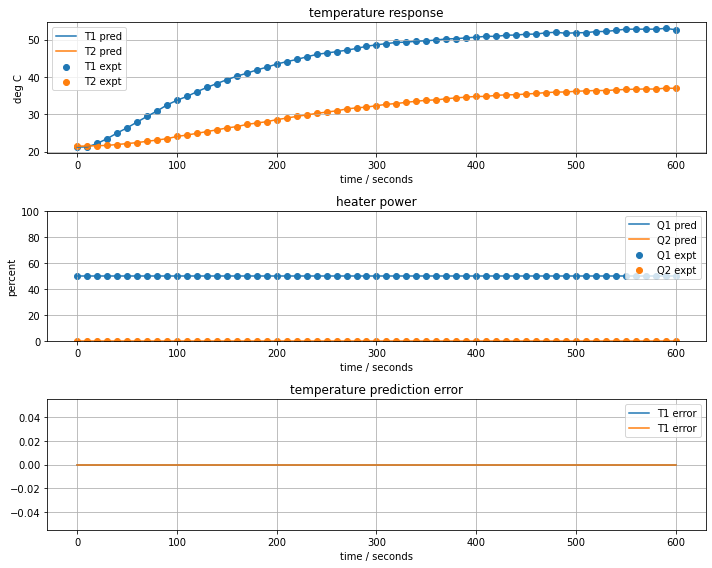

In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# read data file from the Github repository
data_location = "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# create a function to compare two data sets
def plot_data(expt, pred):
    
    t_expt = expt.index

    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("temperature prediction error")
    
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    return ax
    
plot_data(expt, expt);

## 2.4.2 Compute first-order model predictions

We previously developed a model comprising a single differential equation for the temperature response of a heater/sensor assembly. Given $u_1(t)$ and an initial condition $T'(0)$, the deviation of sensor temperature from ambient temperature $T'_1$ is given by 

$$\frac{dT'_1}{dt} = -\frac{U_a}{C_p}T'_1 + \frac{\alpha P_1}{C_p} u_1(t)$$

The sensor temperature is found from the deviation variable by

$$T_1 = T'_1 + T_{amb}$$

Here we show a simulation of this model.

553.2474574329492

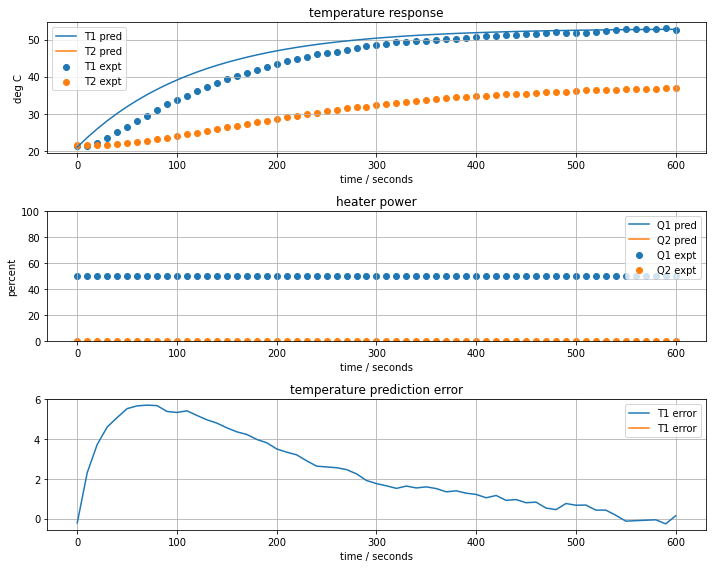

In [180]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# parameter values and units
T_amb = 21             # deg C
P1 = 200               # P1 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# adjustable parameters
Cp = 6                 # joules/deg C
Ua = 0.05              # watts/deg C

# create a list of parameter values
param = [Cp, Ua]

def model_first_order(param, plot=False):
    # unpack the adjustable parameters
    Cp, Ua = param

    # input function
    def u1(t):
        return np.interp(t, t_expt, Q1_expt)

    # model solution
    def deriv(t, y):
        T1_deviation = y[0]
        return -(Ua/Cp)*T1_deviation + (alpha*P1/Cp)*u1(t)

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [0], t_eval=t_expt) 
    T1_pred = soln.y[0] + T_amb
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = T1_pred

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
        
    return err
    
model_first_order(param, plot=True)

## 2.4.3 Find the best fit

[6.00573345 0.0533288 ]


437.774879613566

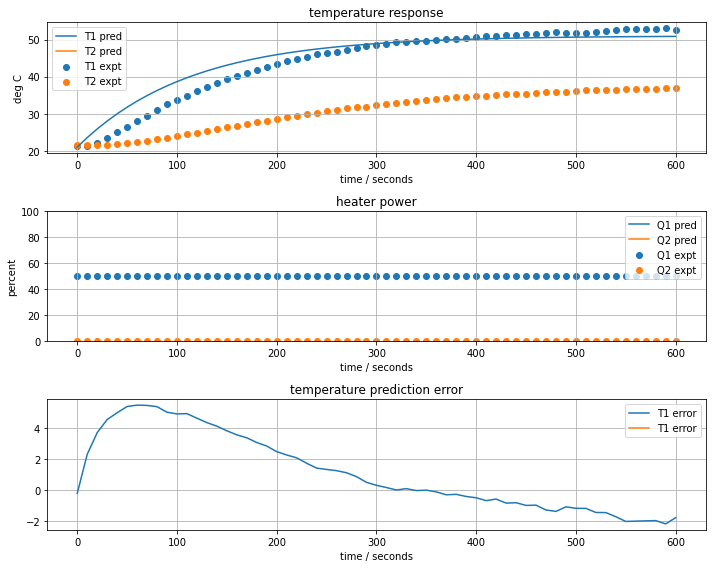

In [181]:
from scipy.optimize import least_squares

result = least_squares(model_first_order, param)
print(result.x)
model_first_order(result.x, plot=True)

## 2.4.4 Second-order model

<!--NAVIGATION-->
< [2.3 First Order Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.03-First-Order-Model-for-a-Single-Heater.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.5 Two State Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.05-Two-State-Model-for-a-Single-Heater.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.04-Model-Fitting.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.04-Model-Fitting.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>